## 1. Introducción

In [5]:
#Lectura de Datos

library(dataseries)
library(forecast)
library(lmtest)
library(car)
library(TSA)
library(FitAR)
library(timsac)
library(xts)

In [6]:
D <- dataseries::ds("TOU.OVR.D")
x = D$TOU.OVR.D
fechas = D$time
n1=which(fechas=="2005-01-01")
n2=which(fechas=="2017-06-01")
x = D$TOU.OVR.D[n1:n2]
fechas = fechas[n1:n2]
np = length(x)

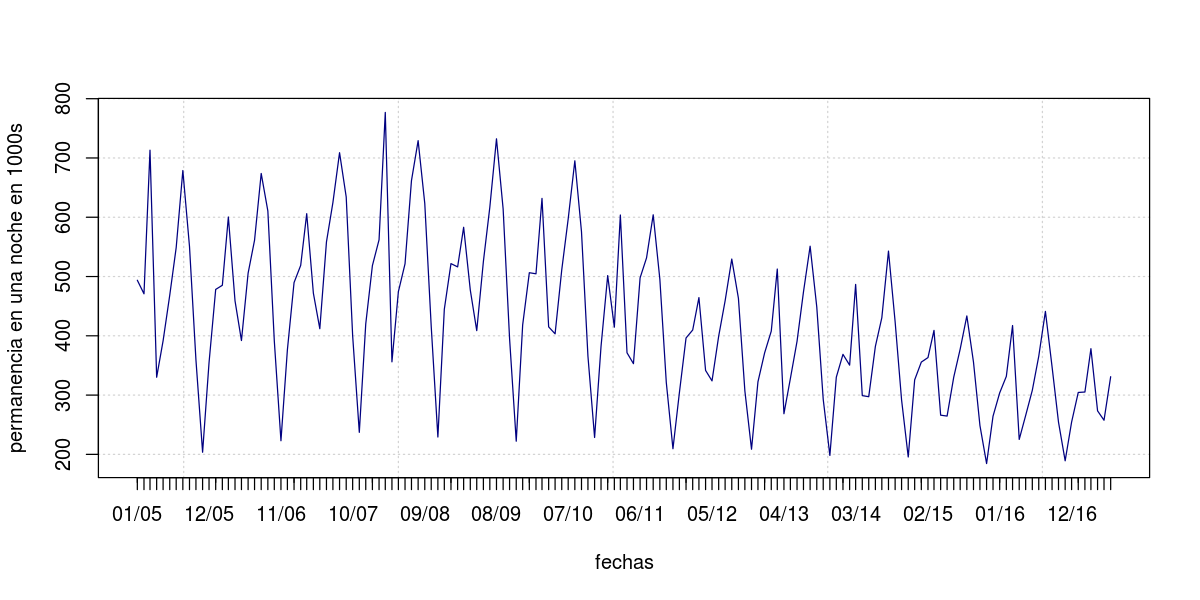

In [7]:
options(repr.plot.width=10, repr.plot.height=5)

ejex.mes = seq(fechas[1],fechas[np], "months")
ejex.año = seq(fechas[1],fechas[np], "years")
plot(fechas,x, xaxt="n", panel.first = grid(),type='l',ylab='permanencia en una noche en 1000s', lwd = 1, col = 'navy')
axis.Date(1, at=ejex.mes, format="%m/%y")
axis.Date(1, at=ejex.año, labels = FALSE, tcl = -0.2)

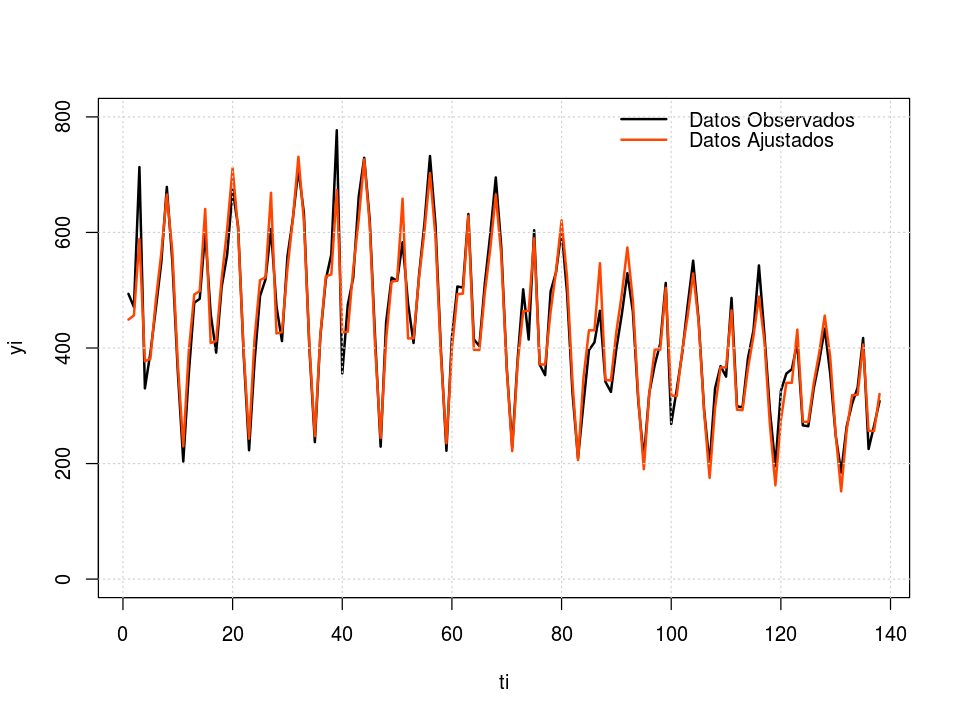

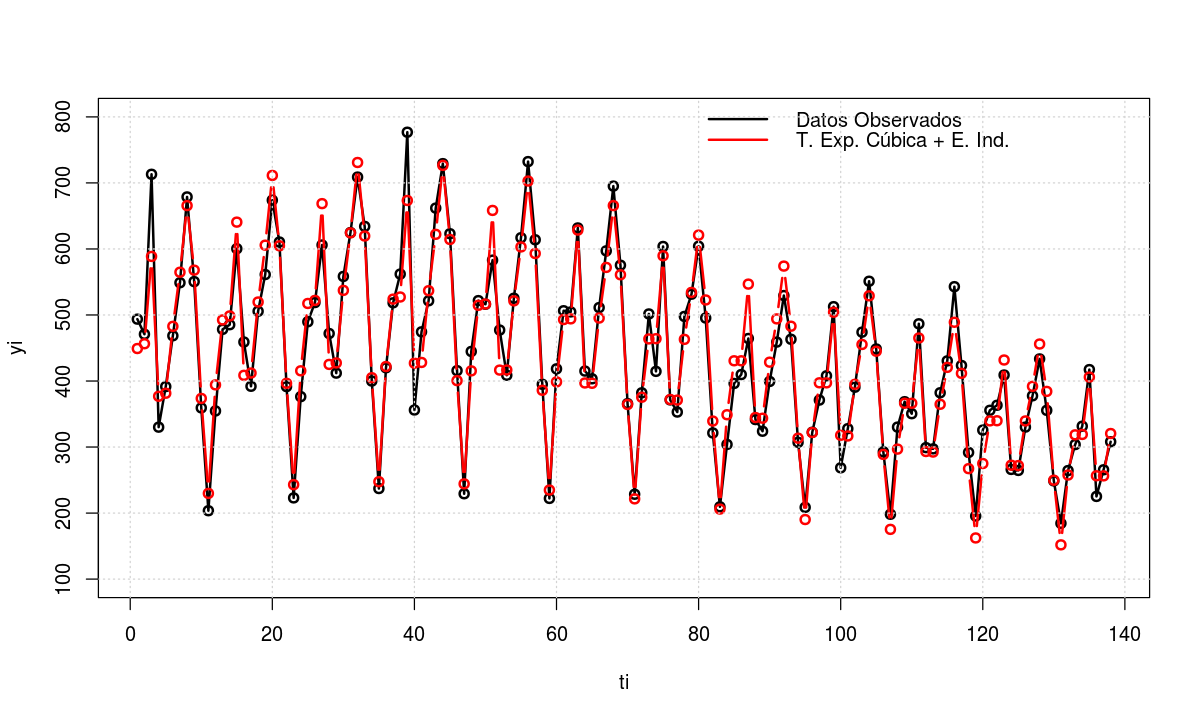

In [8]:
y = ts(x,frequency=12,start=c(2005,1),end=c(2017,6))

#Separacion datos de entrenamiento y de validacion cruzada
#Se separa un año de datos

m = 12
n = length(y)
yi = ts(y[1:(n-m)],frequency=12)
yf = ts(y[(n-m+1):n],frequency=12)

lyi = log(yi) #modelo log-lin

#Tendencia: Lineal + Estacionalidad: Indicadoras

ti = seq(1,length(yi))
ti2 = ti*ti
ti3 = ti2*ti

It = seasonaldummy(yi)

#Tendencia: log cubico + Estacionalidad: Indicadoras
mod8 = lm(lyi ~ ti + +ti2 + ti3 + It)

# El modelo exponencial-cubico-estacional - Indicadoras

T = length(yi)
Xt = cbind(rep(1,T),ti,ti2,ti3,It)
Ds = data.frame(yi,Xt)
theta.0 = mod8$coefficient
mod9 = nls(yi~exp(Xt%*%theta), data=Ds, start= list(theta=theta.0))

yhat9 = fitted(mod9)
r9 <- yi-yhat9
#par(mfrow=c(2,2))
#plot(ti,r9,type='o',ylab='residuo')
#abline(h=0,lty=2)
#plot(density(r9),xlab='x',main= '')
#qqnorm(r9)
#qqline(r9,col=2)

par(mfrow=c(1,1))

options(repr.plot.width=8, repr.plot.height=6)
plot(ti, yi, type = "l", lwd = 2, ylim = c(0,800))
lines(ti, yhat9, col = "orangered1", lwd = 2)
legend( "topright",                              # posicion
        c("Datos Observados","Datos Ajustados"),                 # texto
        lwd = c(2, 2),                          # grosor lineas
        col = c('black','orangered1'),                 # color lineas
        bty = "n")                              # sin caja alrededor de la leyenda
grid()

par(mfrow=c(1,1))

options(repr.plot.width=10, repr.plot.height=6)
plot(ti,yi,type='o', ylim = c(100,800), lwd=2)
lines(ti,yhat9,col = 'red',type='b', lwd =2)

legend("topright", 
    c("Datos Observados","T. Exp. Cúbica + E. Ind."), 
    col = c("black","red"),
    lty=1,
    bty='n', 
    #cex=.75,
    lwd = c(2, 2), )
grid()



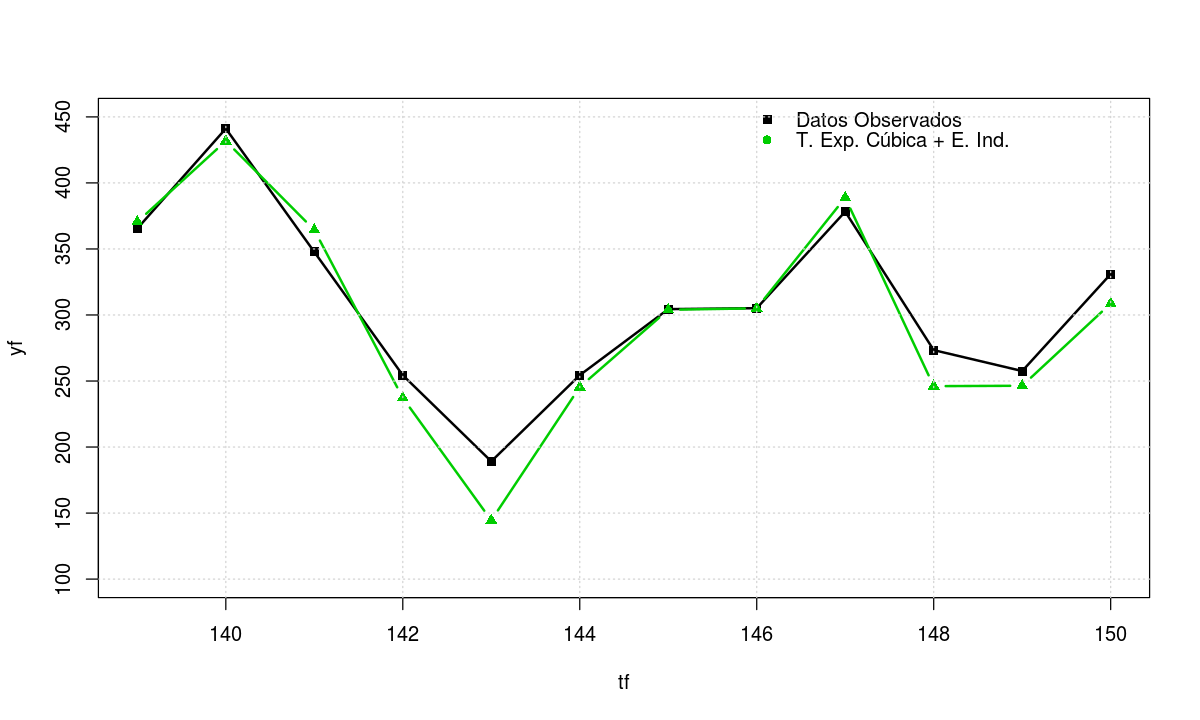

In [9]:
T = length(yi)
Itf = seasonaldummy(yi,m)
tf = seq(T+1,T+m,1)

tf2 = tf*tf
tf3 = tf2*tf
Xtf = cbind(rep(1,m),tf,tf2,tf3,Itf)

pron3 = predict(mod9,data.frame(Xt = I(Xtf)))

par(mfrow=c(1,1))
plot(tf,yf, type = 'o', pch = 15, ylim=c(100,450), lwd=2)
lines(tf,pron3, type = 'b', pch = 17,col='green3', lwd=2 )

legend("topright", c("Datos Observados", "T. Exp. Cúbica + E. Ind."),  bty='n', pch = c(15, 16, 17), 
       col = c("black","green3"))

grid()

Contextualice la serie: definición, frecuencia, perı́odo de los datos, fuente
de los datos (solo si está disponible). Describa el modelo que mejor pronosticó la serie
en el Trabajo No 1. Incluya una gráfica de los pronósticos estructurales versus los datos
observados, para el perı́odo de validación cruzada. Describa el objetivo de su análisis de
acuerdo a los puntos siguientes.

## 2. Pruebas de incorrelación ##

Realice las Pruebas de incorrelación con los residuos
estructurales: Ljung-Box, Durbin-Watson (cuando sea posible), y la gráfica de la fac
y la fac parcial con las bandas de Bartlett. Concluya sobre si los residuos son ruido
blanco o no. De ser posible, identifique un AR(p) ó un MA(q) con estas gráficas.



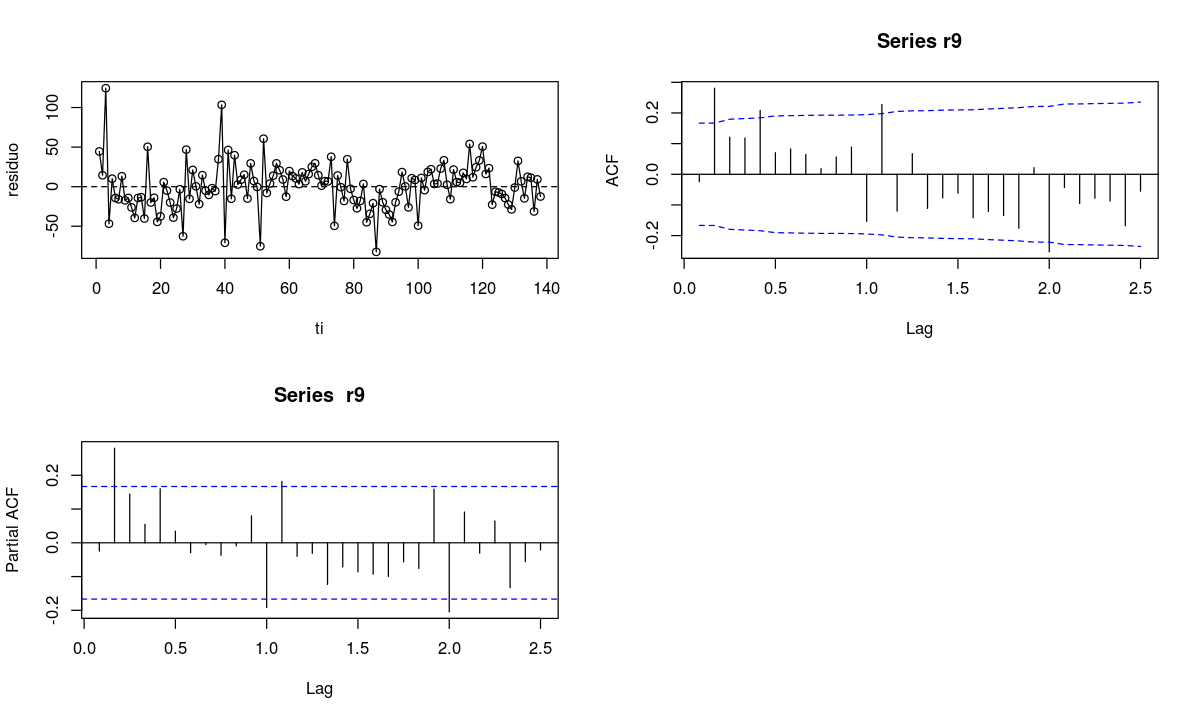

In [10]:
#-------------graficar autocorrelacion (fac)

par(mfrow=c(2,2))
plot(ti,r9,type='o',ylab='residuo')
abline(h=0,lty=2)
acf(r9,30,ci.type="ma")
pacf(r9,30)


In [11]:
cat('Pruebas Box-Ljung')
Box.test(r9, lag = 5 , type =  "Ljung-Box")
Box.test(r9, lag = 15 , type =  "Ljung-Box")
Box.test(r9, lag = 25 , type =  "Ljung-Box")

Pruebas Box-Ljung


	Box-Ljung test

data:  r9
X-squared = 21.708, df = 5, p-value = 0.0005948



	Box-Ljung test

data:  r9
X-squared = 40.372, df = 15, p-value = 0.0003984



	Box-Ljung test

data:  r9
X-squared = 68.957, df = 25, p-value = 5.491e-06


In [12]:
# Se define una nueva serie para agregar el ruido del modelo y poder aplicar DW
     
m_dw <- lm(r9 ~ ti)

#dwtest(m_dw) # de la libreria lmtest

durbinWatsonTest(m_dw,max.lag = 15) # de libreria car

 lag Autocorrelation D-W Statistic p-value
   1     -0.02645121      2.033631   0.896
   2      0.27874281      1.420686   0.002
   3      0.11643249      1.605692   0.052
   4      0.11450047      1.592067   0.028
   5      0.20484650      1.409328   0.000
   6      0.06643548      1.682556   0.128
   7      0.07913294      1.655257   0.112
   8      0.06130401      1.681354   0.212
   9      0.01538833      1.771043   0.458
  10      0.05284372      1.687167   0.250
  11      0.08517716      1.612608   0.148
  12     -0.15715372      2.083252   0.178
  13      0.22455291      1.317485   0.002
  14     -0.12341638      2.011580   0.286
  15      0.06463627      1.622502   0.258
 Alternative hypothesis: rho[lag] != 0

Comentarios....

- Criterios para aceptacion de la prueba Ljung-Box

$H_{0}: {\epsilon}_t$ ~ $RB(0,{\sigma}^2)$

$H_1:$ no ($H_0$)


<span style="color:blue">Si p-value '<'0.05: Se puede rechazar la hipótesis nula suponiendo un 5% de posibilidades de cometer un error. Entonces se puede asumir que sus valores muestran dependencia el uno del otro.</span>


- Criterios para determinar  AR o MA a partir de la grafica

<span style="color:blue">MA(q): Dado que la gráfica de ACF no termina abrutamente, no es posible determinar que la $ \epsilon_{t}$ se trate de una serie tipo MA(q)</span>

<span style="color:blue">De igual manera su PACF no decrece a cero. (Giraldo p.115)</span>

<span style="color:blue">De la PACF se pueden observar los resagos 2, 5, 12 y 13 pasandose de las bandas de Bartlett, sugiriendo un posible modelo AR</span>


- Criterios para aceptacion de la prueba Durbin-Watson

<span style="color:blue"> Se aplica DWG ya se tiene un modelo diferente a un AR(1), y tambien segun (Giraldo, p.99) que d menor a 2 indica posible autocorrelación positiva en la serie. Para la mayoria de los valores de los lag evaluados, este valor es menor a 2, indicando que se presenta autocorrelacion en esos resagos de la serie.</span>

<span style="color:blue">Como refuerzo de lo anterior, en la tabla de DWG se observa que no se trata de un AR(1) ya que el valor de p para el lag 1 es casi 1, mientras que otros lag son menores que 0.05, mostrando que la autocorrelacion es diferente al primer lag.
</span>

## 3. Identificación ##

a) con armasubsets. Identifique un posible modelo ARMA-SARMA mediante la
función armasubsets() de la librerı́a TSA. Recuerde declarar los residuos con
la función ts(et,frequency=), utilizando la misma frecuencia que para la serie
original $Y_t$ . Reporte el modelo.

In [ ]:
#------------identificador armasubsets

r9ts=ts(r9,frequency = 12)

res=armasubsets(y=r9ts,
nar=24,nma=24,
y.name='R9',
ar.method='ols')

par(mfrow=c(1,1))
plot(res)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“7  linear dependencies found”

Reordering variables and trying again:


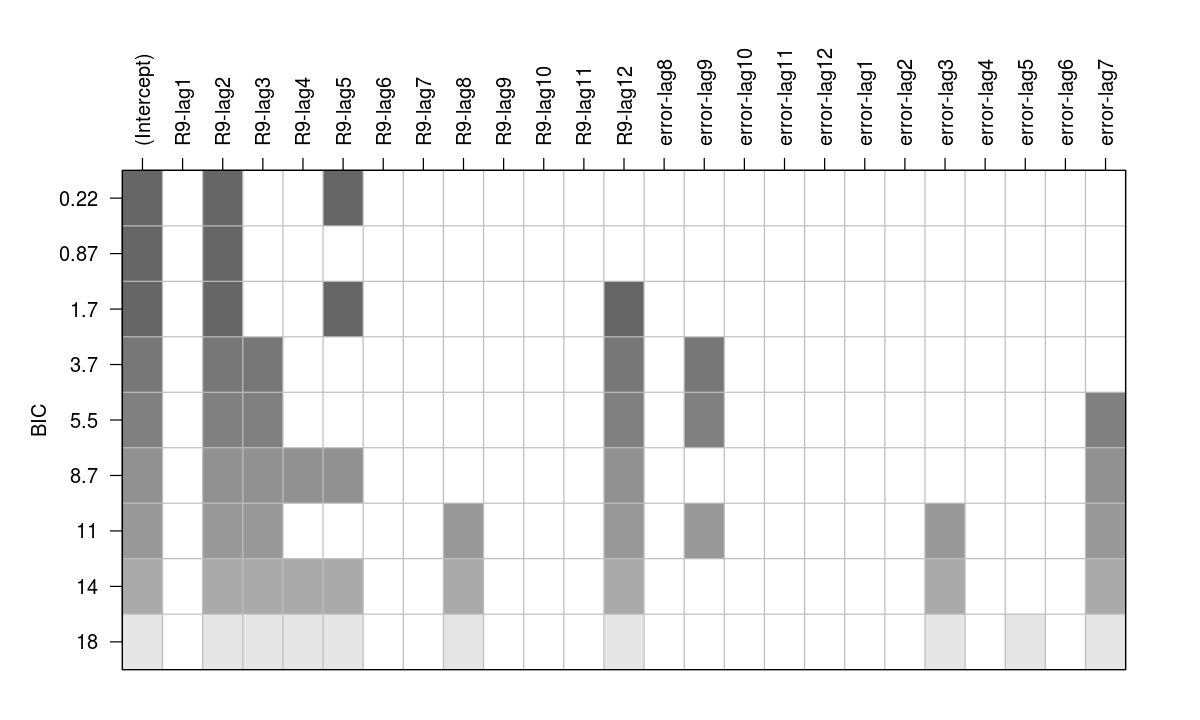

In [14]:
res2=armasubsets(y=r9ts,
nar=12,nma=12,
y.name='R9',
ar.method='ols')

par(mfrow=c(1,1))
plot(res2)

Comentarios

Por tener un alto BIC las componentes MA estarían descartadas, sugiriendose entonces un modelo AR

p = 2;12;13


b) con SelectModel. Identifique un posible modelo AR(p) para los residuos mediante la función SelectModel() de la librerı́a FitAR. Reporte el orden p.

In [15]:
posmod_AR  = SelectModel(r9ts, ARModel=c("AR"), Criterion="AIC", Best=1)

posmod_AR


modres_AR = FitAR(r9,posmod_AR, MeanMLEQ=TRUE)

modres_AR

[1] 5

Warning message in matrix(c(racf, sdRacf), ncol = 2):
“la longitud de los datos [55] no es un submúltiplo o múltiplo del número de filas [28] en la matriz”Warning message in (ra^2)/(n - (1:lag.max)):
“longitud de objeto mayor no es múltiplo de la longitud de uno menor”

AR(5). MLE.  Mean estimated using MLE
length of series = 138 ,  number of parameters = 6
loglikelihood = -458.329 ,  AIC = 928.7 ,  BIC =  946.2

Con la libreria FitAR se sugiere un modelo AR(5).

In [16]:
#Determinar la frecuencia

periodicity(r9)

Monthly periodicity from ene 1 to jun 12 

Se confirma periodicidad mensual(?)

c) con auto.arima. Identifique un posible modelo ARMA-SARMA mediante la
función auto.arima() de la librerı́a forecast. Aplicar las restricciones: stationary=TRUE,
seasonal=TRUE para obtener un modelo estacionario estacional. 
Use el código siguiente. 
Reporte el modelo.  

In [17]:
auto.arima(r9ts, d=NA, D=NA,max.p=24, max.q=24,max.P=24, max.Q=24,
max.order=96, start.p=1, start.q=1, start.P=1, start.Q=1,
stationary=TRUE, seasonal=TRUE,
ic= "aicc", stepwise=TRUE, trace=FALSE,
approximation=(length(r9ts)>100 | frequency(r9ts)>12)) 

Series: r9ts 
ARIMA(3,0,1)(3,0,1)[12] with zero mean 

Coefficients:
          ar1     ar2     ar3     ma1     sar1     sar2    sar3    sma1
      -0.8271  0.3469  0.3241  0.9556  -0.7721  -0.3332  0.1362  0.6586
s.e.   0.0911  0.1066  0.0829  0.0335   0.1638   0.1258  0.1234  0.1507

sigma^2 estimated as 624.2:  log likelihood=-640.42
AIC=1298.84   AICc=1300.25   BIC=1325.19

Con la funcion de Autoarima, y parametrizaciones $p_{max}$ = 24, $q_{max}$ = 24,  $P_{max}$ = 24, $Q_{max}$ = 24, se sugiente un modelo ARIMA(3,0,1)(3,0,1)[12].

d ) con autoarmafit. Identifique un posible modelo ARMA-SARMA mediante la
función autoarmafit() de la librerı́a timsac. Reporte el modelo.

In [21]:
autoarmafit(r9ts)



Case No. 1

 AR coefficient	Standard deviation
 0.510040	0.171361
 0.288832	0.087741

 MA coefficient	Standard deviation
 0.593364	0.170550

 AIC	925.821094
 Innovation variance	784.753963
 Final gradient	9.099423e-02	6.338224e-03	-6.239671e-03


Case No. 2

 AR coefficient	Standard deviation
 0.821756	0.112749

 MA coefficient	Standard deviation
 0.896426	0.130313
 -0.246629	0.086425

 AIC	927.180652
 Innovation variance	792.523466
 Final gradient	-2.315672e-02	-1.886440e-02	4.600005e-02


Case No. 3

 AR coefficient	Standard deviation
 0.475131	0.297659
 0.323499	0.290235

 MA coefficient	Standard deviation
 0.556069	0.312246
 0.035046	0.292926

 AIC	927.805303
 Innovation variance	784.664172
 Final gradient	1.101410e-01	4.706183e-02	7.756202e-02	6.639664e-02


Case No. 4

 AR coefficient	Standard deviation
 0.532835	0.299147
 0.293208	0.093245
 -0.016225	0.144746

 MA coefficient	Standard deviation
 0.613854	0.285739

 AIC	927.805362
 Innovation variance	784.664508
 Final gradient

La funcion autoarmafit sugiere un modelo ARMA(2,1) con un AIC de 925.82.

## 3. Estimación ##

Debe escoger un modelo entre los candidatos encontrados con los métodos anteriores. Una opción es escoger el de menor AIC. Calcule AIC(modelo), con modelo el objeto producido por la función arima(), para cada uno de los posibles
modelos. Con el modelo escogido valide los residuos con el panel de gráficas (fac, facp, qqplot, densidad, periodograma acumulado y la prueba Ljung-Box. En caso de no
obtener ruido blanco ensaye con otro de los modelos encontrados.

In [19]:
#Modelo AR(2)

mod_AR2 <- arima(r9,
    order=c(2,0,0))

comparativo <- data.frame(modelo= numeric(0), AIC= numeric(0))
comparativo[1,]<-c('ARIMA(2,0,0)',AIC(mod_AR2))

#Modelo AR(5)

mod_AR5 <- arima(r9,
    order=c(5,0,0))

comparativo[2,]<-c('ARIMA(5,0,0)',AIC(mod_AR5))

#Modelo AR(12)

mod_AR12 <- arima(r9,
    order=c(12,0,0))

comparativo[3,]<-c('ARIMA(12,0,0)',AIC(mod_AR12))

#Modelo AR(13)

mod_AR13 <- arima(r9,
    order=c(13,0,0))

comparativo[4,]<-c('ARIMA(13,0,0)',AIC(mod_AR13))

#ARIMA(3,0,1)(3,0,1)[12]

mod_ARIMA301 = arima(r9,
    order=c(3,0,1),
    seasonal = list(
    order = c(3, 0, 1),
    period = 12))
                     
comparativo[5,]<-c('ARIMA(3,0,1)(3,0,1)[12]',AIC(mod_ARIMA301))

#ARIMA(2,0,1)

mod_ARIMA201 = arima(r9,
    order=c(2,0,1))
                     
comparativo[6,]<-c('ARIMA(2,0,1)',AIC(mod_ARIMA201))
comparativo

modelo,AIC
"ARIMA(2,0,0)",1324.31767019664
"ARIMA(5,0,0)",1322.2840515037
"ARIMA(12,0,0)",1327.90244794175
"ARIMA(13,0,0)",1324.87719633043
"ARIMA(3,0,1)(3,0,1)[12]",1300.83925766167
"ARIMA(2,0,1)",1320.60579523673


Segun se pudo contrastar, el mejor AIC calculado con la funcion ARIMA es ARIMA(3,0,1)(3,0,1)[12], estando con notoriedad
por debajo de los modelos que partieron de las graficas de ACF y PACF, subsetmodels y autoarmafit.

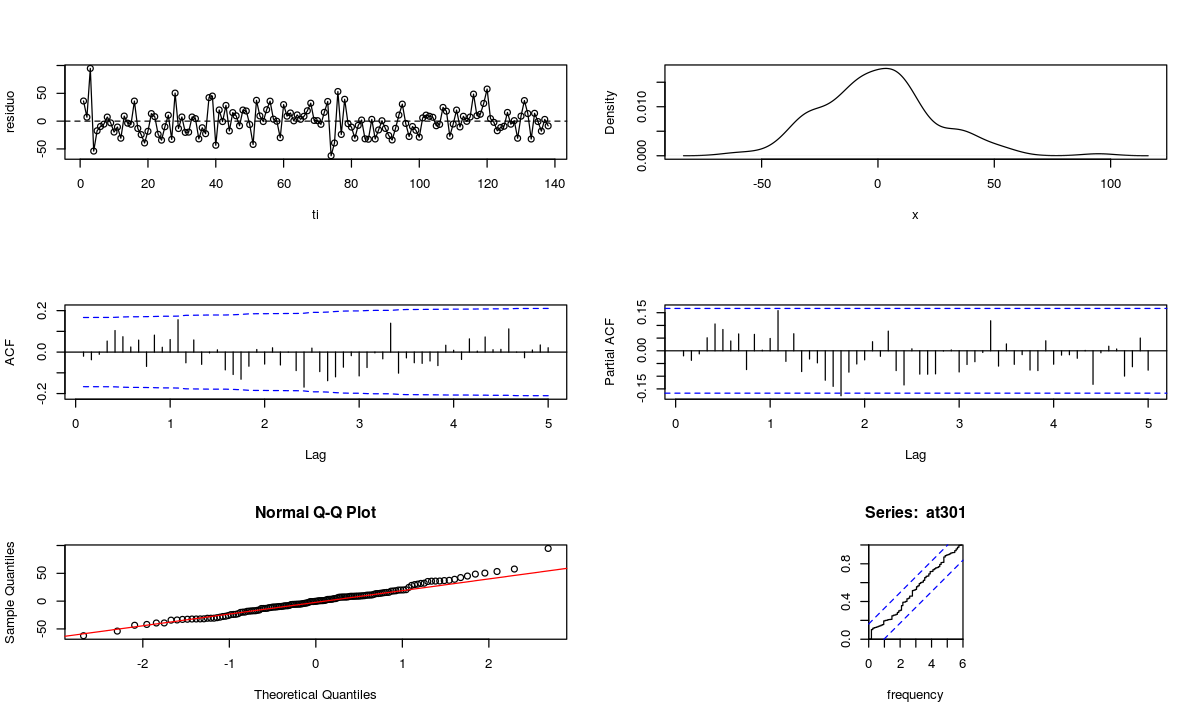

In [22]:
#Validacion con ARIMA(3,0,1)(3,0,1)[12]

at301 = mod_ARIMA301$residuals

par(mfrow=c(3,2))
plot(ti,at301,type='o',ylab='residuo')
abline(h=0,lty=2)
plot(density(at301),xlab='x',main= '')
acf(at301,ci.type= "ma",60,main="")
pacf(at301,60,main="")
qqnorm(at301)
qqline(at301,col=2)
cpgram(at301)

In [30]:
Box.test(x = at301, lag = 25, type="Ljung-Box")


	Box-Ljung test

data:  at301
X-squared = 18.618, df = 25, p-value = 0.815


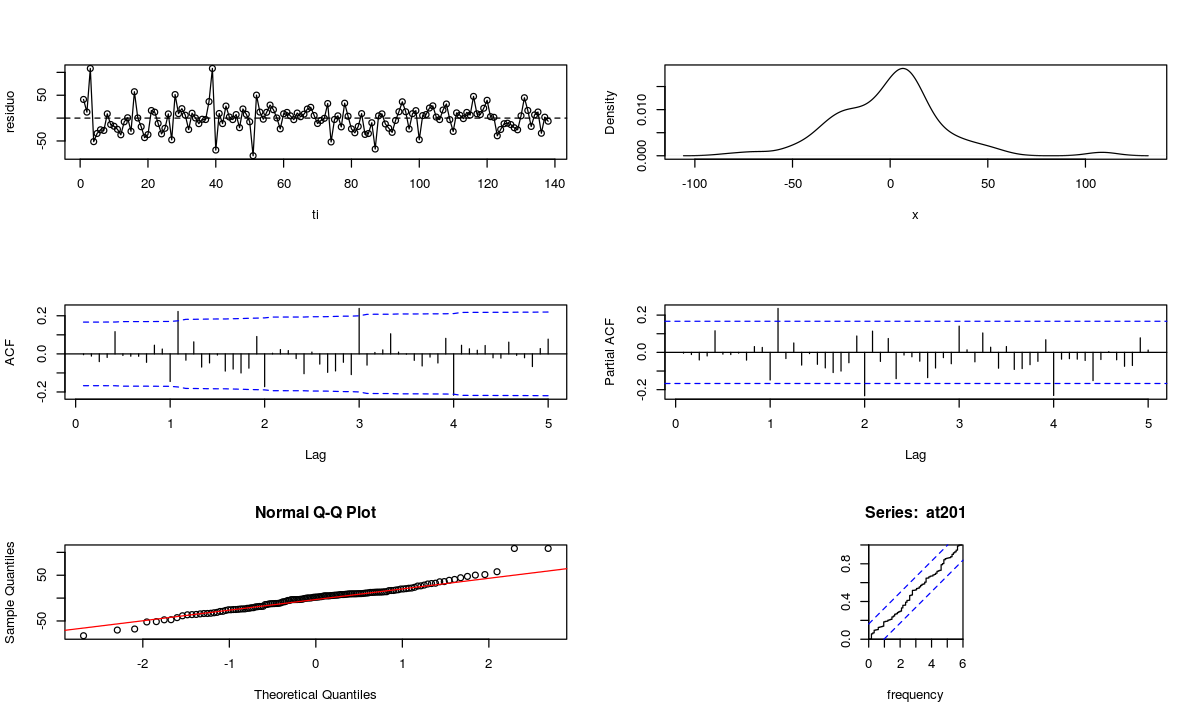

In [24]:
#Validacion con AR(5)

at201 = mod_ARIMA201$residuals

par(mfrow=c(3,2))
plot(ti,at201,type='o',ylab='residuo')
abline(h=0,lty=2)
plot(density(at201),xlab='x',main= '')
acf(at201,ci.type= "ma",60,main="")
pacf(at201,60,main="")
qqnorm(at201)
qqline(at201,col=2)
cpgram(at201)

In [31]:
Box.test(x = at201, lag = 25, type="Ljung-Box")


	Box-Ljung test

data:  at201
X-squared = 27.144, df = 25, p-value = 0.3487


Comentarios

sadsadsafdsafdsafdsafdsafsafdsfdsaf
dsafsafdsadf
dsafsafdsafsadf
dsfdsafdsafa

dsafdfasd

## 4. Pronósticos ## 

Calcule pronósticos de los residuos estructurales con el modelo determinado en el punto anterior. Añádalos a los pronósticos estructurales del Trabajo No 1. Reporte el MAPE de estos dos conjuntos de pronósticos y reporte si el modelo
ARMA-SARMA mejora los pronósticos estructurales.

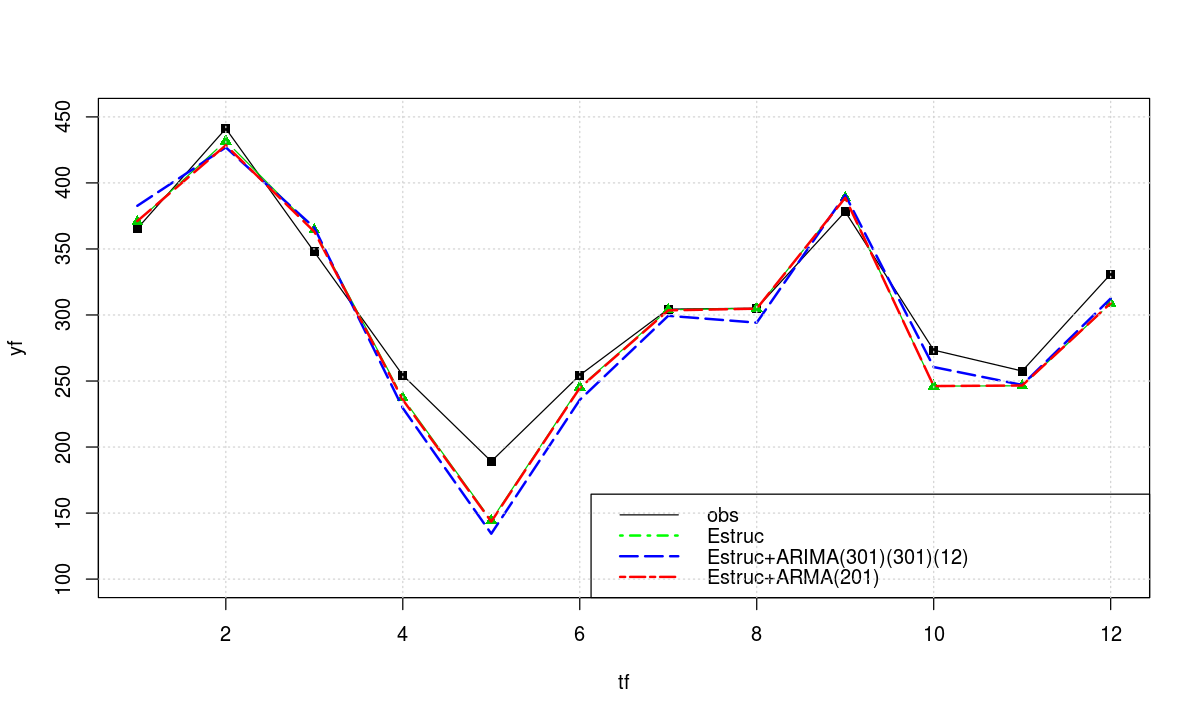

In [27]:
# --- con el estructural + ARIMA(3,0,1)(3,0,1)[12]

p.arima301 <- predict(mod_ARIMA301,n.ahead = 12)$pred
p.tot.1 = pron3 + p.arima301

p.ar201 <- predict(mod_ARIMA201, n.ahead=12)$pred
p.tot.2 = pron3 + p.ar201

par(mfrow=c(1,1))
tf = seq(1,length(yf),1)
plot(tf,yf, type = 'o', pch = 15, ylim=c(100,450))
lines(tf,pron3, type = 'b', pch = 17,col='green3')
lines(tf,p.tot.1,lty=5,lwd=2,col='blue')
lines(tf,p.tot.2,lty=5,lwd=2,col='red')

legend("bottomright",
c("obs","Estruc","Estruc+ARIMA(301)(301)(12)","Estruc+ARMA(201)"),
lty = c(1,4,5,6),
lwd=c(1,2,2,2),
col=c("black","green","blue","red") )
grid()

In [29]:
A=rbind(
accuracy(ts(pron3,frequency = 12),yf),
accuracy(as.vector(p.tot.1),yf),
accuracy(as.vector(p.tot.2),yf))
rownames(A)=c("Estructural","E+ARIMA","E+ARMA(2,1)")
(A)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Estructural,9.113066,18.80009,14.48104,4.027165,5.518430,0.007624608,0.2973005
E+ARIMA,10.180191,21.84885,18.22402,4.631480,6.855724,0.059104363,0.3545986
"E+ARMA(2,1)",9.710040,19.15553,14.95503,4.220447,5.675218,-0.020863456,0.3031354


## Conclusiones ## 

Presente conclusiones sobre los resultados.